###Author: Toufiq Musah, https://github.com/toufiqmusah

#What is the Machine Learning Workflow?

---
1.  Define your problem. Is it relevant to Machine Learning(Data Related)
2.  Gather and prepare your dataset.
3.  Select the right model for the job. Will it be a Deep Learning(DL) or Machine Learning(ML) model.
4.  Train your model on the dataset, and perform validation.
5.  Fine-Tune your model to get better results(Will you need to expand the dataset and retrain? Do some hyperparameters need to change?)
6.  Deploy your solution.
---
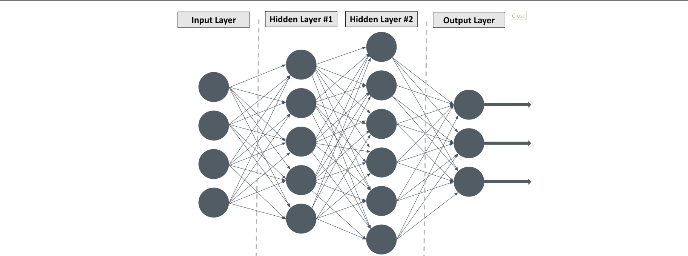


# WHAT IS OUR WORKFLOW TODAY?


---


1.  Cases of pneumonia are on the rise, and the clinicians are swamped with too many cases to assess and diagnosis. Why not help them automate the process a little?
2.  We will gather a dataset of chest x-rays of patients with and without pneuomonia. Luckily, a public dataset called the [MedMNIST](https://medmnist.com/) already contains that.The data preparation task can be a little tough.
3.  Since it is an image related task, we will go with a Deep Learning approach. Specifically using Convolutional Neural Networks(CNNs)
4.  We will define our CNN with its various layers and set it up to perform image classification and classify pneumonia x-ray scans from non-pneumonia ones.
5.  Based on the performance of the model, the model will be optimised, fine-tuned and saved.
---


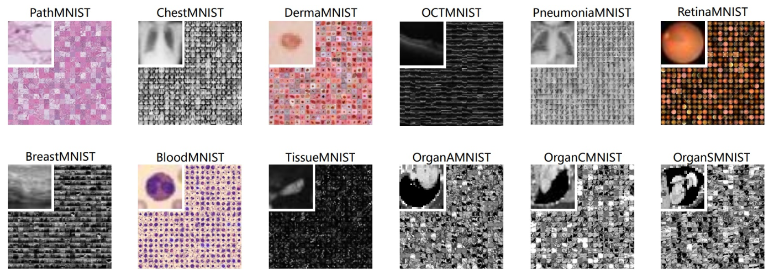

### Data Acquisition and Exploration

In [ ]:
#Let's start by importing some of the necessary libraries for the job at hand.
#We will be using the TensorFlow & Keras Libraries for this endeavour.
# I often prefer PyTorch for computer vision tasks like this, but TensorFlow can be more beginner friendly.

import numpy as np # To load and manipulate numerical data
import matplotlib.pyplot as plt # To plot images, etc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical # To perform One-hot encoding
from tensorflow.keras import layers, models, Model

In [ ]:
# The MedMNIST dataset we wish to use exists as a library we can install and use.
# This means that we don't have to manually download and import the data into the notebook
# Do note that it is not always this easy

!pip -q install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# We will import the medmnist library and look at the available datasets
# Note that I read the documentation on MedMNIST before knowing how to use it
# Lesson of the story: READ DOCUMENTATION!!!

import medmnist

!python -m medmnist available

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist       | PathMNIST       | Size: 28 (default), 64, 128, 224.
	chestmnist      | ChestMNIST      | Size: 28 (default), 64, 128, 224.
	dermamnist      | DermaMNIST      | Size: 28 (default), 64, 128, 224.
	octmnist        | OCTMNIST        | Size: 28 (default), 64, 128, 224.
	pneumoniamnist  | PneumoniaMNIST  | Size: 28 (default), 64, 128, 224.
	retinamnist     | RetinaMNIST     | Size: 28 (default), 64, 128, 224.
	breastmnist     | BreastMNIST     | Size: 28 (default), 64, 128, 224.
	bloodmnist      | BloodMNIST      | Size: 28 (default), 64, 128, 224.
	tissuemnist     | TissueMNIST     | Size: 28 (default), 64, 128, 224.
	organamnist     | OrganAMNIST     | Size: 28 (default), 64, 128, 224.
	organcmnist     | OrganCMNIST     | Size: 28 (default), 64, 128, 224.
	organsmnist     | OrganSMNIST     | Size: 28 (default), 64, 128, 224.
	organmnist3d    | OrganMNIST3D    | Size: 28 (default), 64.
	nodule

In [ ]:
# Let's Download the Pneumonia training and testing dataset for the task

data_path = '/content/' # The path the dataset will be downloaded into.

train_dataset = medmnist.PneumoniaMNIST(split = 'train', download = True, size = 128, root = data_path)
test_dataset = medmnist.PneumoniaMNIST(split = 'test', download = True, size = 128, root = data_path)

100%|██████████| 75506212/75506212 [00:00<00:00, 116997600.18it/s]


Using downloaded and verified file: /content/pneumoniamnist_128.npz


In [ ]:
# Now that the dataset has been downloaded, let's load it with numpy and see what it contains
# The dataset we have is already split into the training, validation and testing.
# This is not always the case

data = np.load('/content/pneumoniamnist_128.npz')
data.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

In [ ]:
data['train_images'].shape

(4708, 128, 128)

(-0.5, 127.5, 127.5, -0.5)

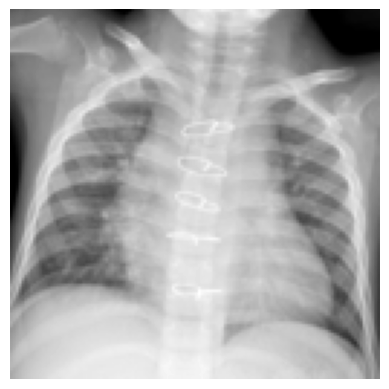

In [ ]:
plt.imshow(data['train_images'][0], cmap = 'gray')
plt.axis('off')

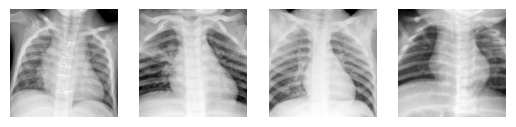

In [ ]:
# Let's see what the images look like using the Matplotlib library - plt

plt.subplot(1, 4, 1)
plt.imshow(data['train_images'][0], cmap = 'gray')
plt.axis('off')
plt.subplot(1, 4 ,2)
plt.imshow(data['train_images'][1], cmap = 'gray')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(data['train_images'][2], cmap = 'gray')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(data['train_images'][10], cmap = 'gray')
plt.axis('off')
plt.show()

### Data Preparation Stage Begins

In [ ]:
# We will create our training, validation and testing split variables below
# The test split is not always necessary though

(train_images, train_labels) = (data['train_images'], data['train_labels'])
(val_images, val_labels) = (data['val_images'], data['val_labels'])
(test_images, test_labels) = (data['test_images'], data['test_labels'])

# We will continue by normalising the images. i.e [0, 255] -> [0, 1]
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Let's reshape the images so they can fit well into the model later
# Going from: [Batch, Height, Width] -> [Batch, Height, Width, Channels]
train_images = tf.reshape(train_images, (-1, 128, 128, 1))
val_images = tf.reshape(val_images, (-1, 128, 128, 1))
test_images = tf.reshape(test_images, (-1, 128, 128, 1))

# Let's one-hot encode the labels (Removes ordinality, and can improve model performance)
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

In [ ]:
train_images.shape

TensorShape([4708, 128, 128, 1])

(-0.5, 127.5, 127.5, -0.5)

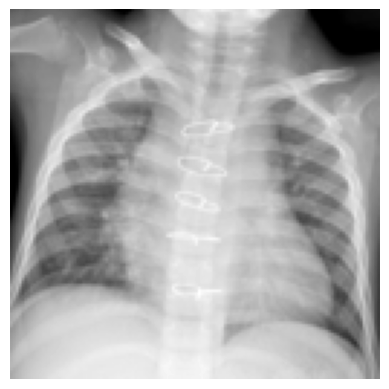

In [ ]:
# Notice that the images will still look same after normalising.

plt.imshow(train_images[0], cmap = 'gray')
plt.axis('off')

In [ ]:
# We are in the endgame of data preprocessing now.
# Let's convert the numpy data into the right format for trainiing on TensorFlow (i.e Tensors)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
# We call them "train_dataset, etc" because they contains both the images and labels

In [ ]:
# We will continue by shuffling and the batching dataset
# Batching ensure that the model trains on a subset of the dataset at a time
# This is important to reduce computational costs, as well as prevent overfitting

train_dataset = train_dataset.shuffle(buffer_size = 1024).batch(batch_size = 64)
val_dataset = val_dataset.batch(batch_size = 64)
test_dataset = test_dataset.batch(batch_size = 64)

train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

### Model Implementation

Remember that since it is an (computer vision)/(imaging) task, we chose to go with a deep learning model. Particularly, the Convolutional Neural Network (CNN). The CNN is made up of 3 main types of layers.
- Convolutional Layer: To detect features and patterns in images
- Pooling Layer: To remove complexities and extract dominant features
- Dense(Linear) Layer: To perform classification based on the extracted features
- We also have dropout layers which reduce overfitting, and activation functions that introduce non-linearity. Non-Linearity allows us to work with very complex data.
---
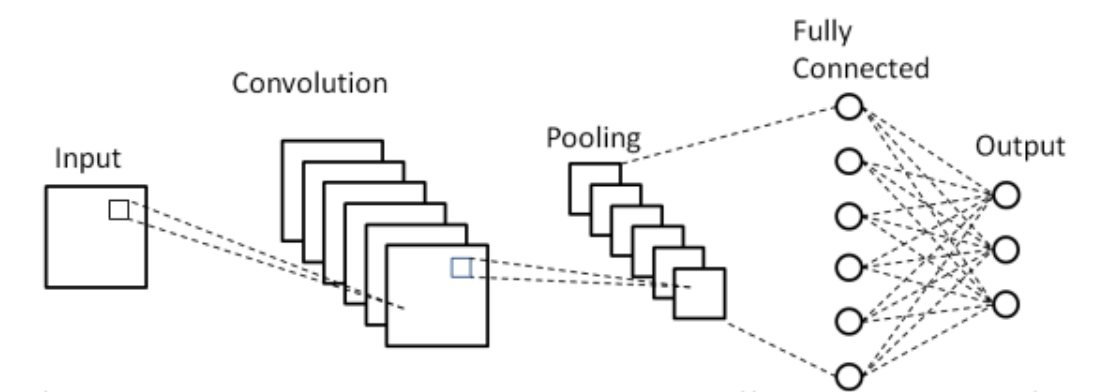
---

In [ ]:
# Finally done with image preprocessing. That wasn't fun at all.
# Let's get to the exciting part and make that model.
# We are going to implement a TensorFlow Sequential model.


model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 128x128 with 1, representing grayscale color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(128, 128, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    # Flatten the results to feed into a Dense Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
    # We use softmax because the labels were One-hot encoded.
    # Otherwise, this is a binary classifcation task, and the activation will have been 'sigmoid'.
])

model.summary() # This will give us a brief summary of the model, showing how features move from one layer to another.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 731,778 (2.79 MB)

 Trainable params: 731,778 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training and Evaluation

In [ ]:
# We will now define the hyperparameters with which our model will learn with.
# In the model.comnpile phase; we select a loss function (which helps the model know how right or wrong its is),
# the optimizer will update the weights of the neural network based on the loss,
# and metrics, which tells the model what metrics to prioritise in the learning process.

# In the model.fit phase, we parse the training and validation datasets,
# as well as setting an epoch count which tells the model how many times to iterate over the entire dataset

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10, validation_data = val_dataset, verbose = 1)

model.save('Pneumonia-Model.keras')

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9381 - loss: 0.1571 - val_accuracy: 0.9447 - val_loss: 0.1348
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9416 - loss: 0.1561 - val_accuracy: 0.9313 - val_loss: 0.1612
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9497 - loss: 0.1265 - val_accuracy: 0.9504 - val_loss: 0.1402
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9545 - loss: 0.1239 - val_accuracy: 0.9447 - val_loss: 0.1455
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9537 - loss: 0.1226 - val_accuracy: 0.9485 - val_loss: 0.1347
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9492 - loss: 0.1210 - val_accuracy: 0.9389 - val_loss: 0.1526
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9473 - loss: 0.1277 - val_accuracy: 0.8969 - val_loss: 0.2029
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9560 - loss: 0.1219 - val_accuracy: 0.9141 - 

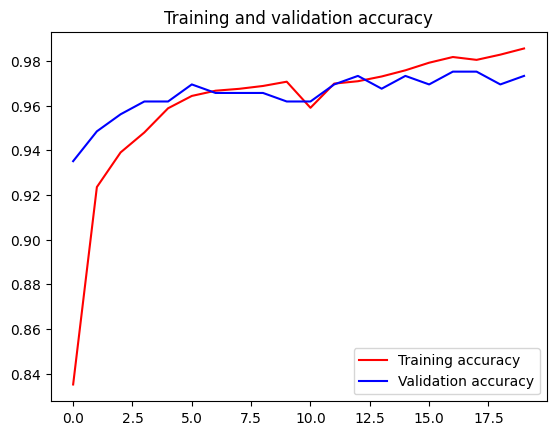

<Figure size 640x480 with 0 Axes>

In [ ]:
# How did the model perform in training and validation?

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### Explainability

How would we know if our model is learning using the right features?<br>
Are the feeatures clinically relevant? Can we somewhat trust this model?<br>

The best answer to all of this is Explainable AI. Maybe in another notebook in the future

# References

1. https://medmnist.com/
2. Tensorflow Zero to Hero: https://youtube.com/playlist?list=PLQY2H8rRoyvwWuPiWnuTDBHe7I0fMSsfO&si=kwRugxgtYSgrECYV